<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/firstXAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
# from scikeras.wrappers import KerasRegressor

In [2]:
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
def generate_fake_weather_data(n=1000):
  """
  Creation of fake weather data with some realistic considerations.
  Args:
    n (int): number of samples
  Returns:
    X (pd.DataFrame): features
    y (pd.Series): target
  """
  # Temperature (with seasonal variation)
  time = np.arange(n)
  temp_base = 20 + 10 * np.sin(2 * np.pi * time / 365)  # Yearly cycle
  temperature = temp_base + np.random.normal(0, 3, n)

  # Humidity (inversely related to temperature, with noise)
  humidity = 80 - 0.5 * temperature + np.random.uniform(-10, 10, n)
  humidity = np.clip(humidity, 30, 95)  # Keep within reasonable bounds

  # Pressure (relatively stable, with occasional fluctuations)
  pressure = 1013 + np.random.normal(0, 5, n)
  # Create a single random mask to ensure consistent indexing:
  mask = np.random.rand(n) < 0.05
  pressure[mask] = pressure[mask] + np.random.normal(0, 20, np.count_nonzero(mask)) # Occasional storms

  # Wind Speed (more wind when pressure is low)
  wind_speed = 5 + 0.2 * (1013 - pressure) + np.random.uniform(0, 5, n)
  wind_speed = np.clip(wind_speed, 0, 25)

  # Solar Radiation (high during the day, low at night, seasonal)
  day_night_cycle = np.sin(2 * np.pi * time / 24)  # Daily cycle
  solar_radiation = 500 * day_night_cycle * (1 + 0.5 * np.sin(2 * np.pi * time / 365)) # Seasonal and Daily
  solar_radiation = np.clip(solar_radiation, 0, 800)

  X = pd.DataFrame({
      'temperature': temperature,
      'humidity': humidity,
      'pressure': pressure,
      'wind_speed': wind_speed,
      'solar_radiation': solar_radiation
  })
  y = X['temperature'] + 0.1 * X['humidity'] - 0.05 * X['wind_speed'] + np.random.normal(0, 1, n)
  return X, y

In [4]:
X, y = generate_fake_weather_data(n=1000)

In [5]:
X

,temperature,humidity,pressure,wind_speed,solar_radiation
0,25.292157,73.792000,1013.225829,9.520590,0.000000e+00
1,21.372605,73.324270,1022.296732,7.723537,1.305233e+02
2,23.280430,76.021337,1004.868390,9.269479,2.543027e+02
3,27.238876,75.712064,1012.325888,8.345349,3.626785e+02
4,26.290698,72.349603,1010.079532,6.144500,4.479089e+02
...,...,...,...,...,...
995,11.351837,74.394638,1008.225286,7.701674,6.543738e+01
996,9.493663,77.670000,1011.490424,7.541717,1.062836e-11
997,10.350008,81.484765,1018.052138,7.886958,0.000000e+00
998,6.606114,77.988885,1015.480897,8.792344,0.000000e+00


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True, stratify=None,
    )

In [7]:
X_train.shape, X_test.shape, y_train.values.reshape(-1, 1).shape, y_test.values.reshape(-1, 1).shape

((800, 5), (200, 5), (800, 1), (200, 1))

In [8]:
scalerfeat = MinMaxScaler()
X_train_scaled = scalerfeat.fit_transform(X_train)

scalerlabel = MinMaxScaler()
y_train_scaled = scalerlabel.fit_transform(y_train.values.reshape(-1, 1))

X_test_scaled = scalerfeat.transform(X_test)
y_test_scaled = scalerlabel.transform(y_test.values.reshape(-1, 1))

In [9]:
X_train_scaled.max(axis=0)

array([1., 1., 1., 1., 1.])

In [10]:
y_train_scaled.max(axis=0)

array([1.])

In [11]:
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])

In [12]:
model.compile(optimizer='adam', loss='mse')

In [13]:
preds = model.predict(X_test)
score = r2_score(y_test, preds)
print(f"R2 Score: {score:.3f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R2 Score: -7035.182


In [14]:
history = model.fit(
    X_train, y_train, epochs=10, verbose=1, validation_split=0.2, shuffle=True
    )

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 368535.7812 - val_loss: 264238.4062
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 244624.4375 - val_loss: 167988.0781
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 155737.8750 - val_loss: 103036.3203
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 96178.7656 - val_loss: 61675.0195
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 58280.8438 - val_loss: 36763.5430
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 35310.2617 - val_loss: 22600.7441
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21976.2676 - val_loss: 14780.7471
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14386.0430 - val_loss: 10366.9277
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9969.2412 - val_loss: 7716.2095
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7276.2886 - val_loss: 6004.7764


In [15]:
def permutation_feature_importance(model, X, y, metric=None, n_repeats=5, seed=42):
    """
    Compute permutation feature importance for a Keras regression model.

    Parameters:
    - model: trained Keras model
    - X: numpy array of shape (n_samples, n_features)
    - y: true target values, shape (n_samples,)
    - metric: function to evaluate performance, default is mean squared error
    - n_repeats: number of shuffles per feature
    - seed: random seed for reproducibility

    Returns:
    - Dictionary mapping feature index to importance score
    """
    np.random.seed(seed)
    if metric is None:
        def metric(y_true, y_pred):
            return np.mean((y_true - y_pred) ** 2)  # MSE

    baseline_score = metric(y, model.predict(X))
    importances = {}

    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_perm = X.copy()
            np.random.shuffle(X_perm[:, i])  # Shuffle only the i-th column
            permuted_score = metric(y, model.predict(X_perm))
            scores.append(permuted_score)
        importances[i] = np.mean(scores) - baseline_score  # Increase in error

    return importances

In [16]:
permutation_feature_importance(model, X_test_scaled, y_test_scaled, metric=None, n_repeats=5, seed=42)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


{0: np.float64(-0.0106044665148608),
 1: np.float64(0.043074567453634804),
 2: np.float64(-0.005518932114225494),
 3: np.float64(-0.0008396582124976515),
 4: np.float64(-0.030016435838198685)}

# Shapley

The core idea behind Shapley value based explanations of machine learning models is to use fair allocation results from cooperative game theory to allocate credit for a model’s output among its input features.

In order to connect game theory with machine learning models, it is necessary to both match a model’s input features with players in a game, and also match the model function with the rules of the game.

Since in game theory a player can join or not join a game, we need a way for a feature to “join” or “not join” a model. The most common way to define what it means for a feature to “join” a model is to say that feature has “joined a model” when we know the value of that feature, and it has not joined a model when we don’t know the value of that feature.

To evaluate an existing model when only a subset of features are part of the model we integrate out the other features using a conditional expected value formulation.

From: https://pypi.org/project/shap/

In [17]:
X100 = shap.utils.sample(X_train_scaled, 100)  # 100 instances for use as the background distribution

explainer = shap.Explainer(model, X100)
shap_vals = explainer(X_test_scaled)

In [18]:
shap_vals.shape

(200, 5)

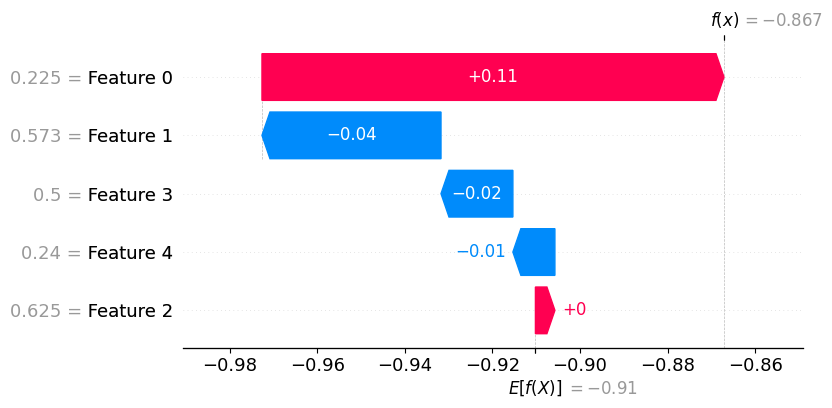

In [19]:
# Plots an explanation of a single prediction as a waterfall plot.
# The SHAP value of a feature represents the impact of the evidence provided by that feature on the model's output.
# The waterfall plot is designed to visually display how the SHAP values (evidence) of each feature
# move the model output from our prior expectation under the background data distribution, to the final model
# prediction given the evidence of all the features.
sample_ind = 0
shap.plots.waterfall(shap_vals[sample_ind], max_display=14)

<ipython-input-20-3ceb25de3982>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_test_scaled, feature_names=feature_names)


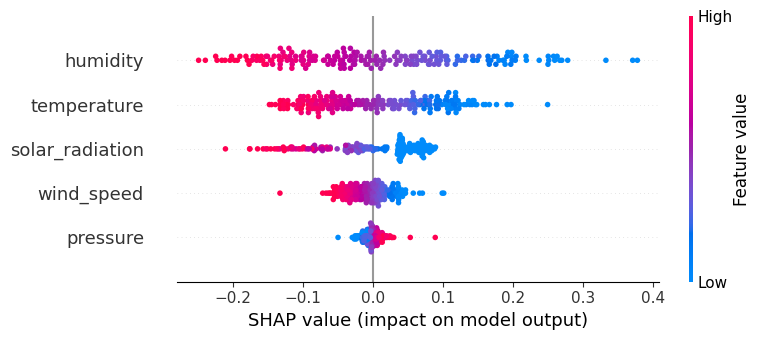

In [20]:
feature_names = X_train.columns
# Create a SHAP beeswarm plot, colored by feature values when they are provided.
shap.summary_plot(shap_vals, X_test_scaled, feature_names=feature_names)

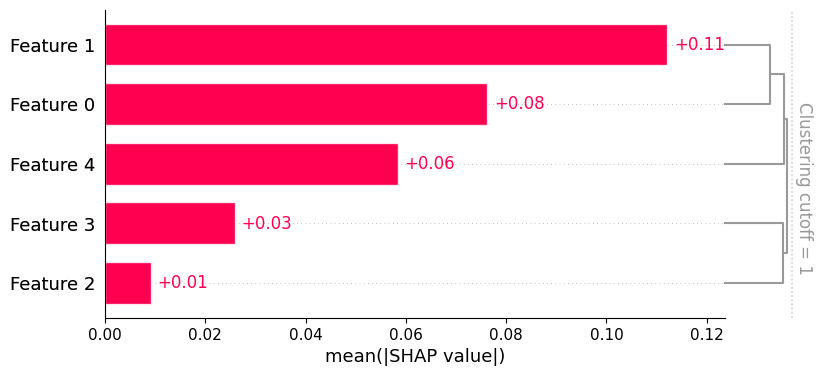

In [21]:
# plotting the global importance of each feature in the model
clust = shap.utils.hclust(X_test_scaled, y_test_scaled, linkage="single")
shap.plots.bar(shap_vals, clustering=clust, clustering_cutoff=1)

When features merge together at the bottom (left) of the dendrogram it means that that the information those features contain about the outcome (renewal) is very redundant and the model could have used either feature.

When features merge together at the top (right) of the dendrogram it means the information they contain about the outcome is independent from each other.

In [22]:
def sage_approx_keras(model, X, y):
  """
  approximation of the SAGE (Shapley Additive Global Importance) method for calculating feature importance in a Keras model.
  SAGE is based on Shapley values, a concept from game theory used to fairly distribute the contribution of each player in a cooperative game.
  In the context of machine learning, it's used to determine the importance of each feature in a model's prediction.
  """
  # establish a baseline
  base_loss = model.evaluate(X, y, verbose=0)
  # iterate thru the features
  importances = []
  for col in X.columns:
    # permute feature and evaluate
    X_permuted = X.copy()
    X_permuted[col] = np.random.permutation(X_permuted[col])
    permuted_loss = model.evaluate(X_permuted, y, verbose=0)
    # calculate and store importances
    importances.append(permuted_loss - base_loss)
  return importances

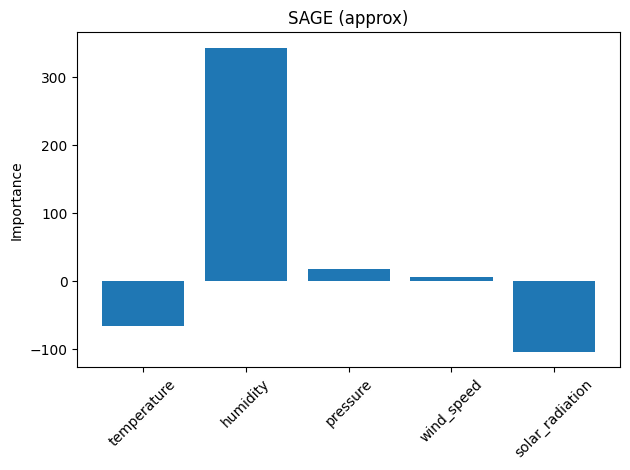

In [23]:
sage_vals = sage_approx_keras(model, X_test, y_test)
plt.bar(feature_names, sage_vals)
plt.title("SAGE (approx)")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
def compute_saliency_map_keras(model, X):
  """
  This function aims to compute the saliency map for a given Keras model and input data X.
  In simpler terms, it helps us understand which features in the input data are most influential on the model's predictions.
  """
  X_tensor = tf.convert_to_tensor(X.values, dtype=tf.float32)

  # calculate gradients
  # gradient tape is a tf tool for computing gradients
  # (how much the output changes with respect to small changes in the input)
  with tf.GradientTape() as tape:
    # track how the X_tensor affects the output
    tape.watch(X_tensor)
    preds = model(X_tensor)

  # alculates the gradients of the predictions (preds) with respect to the input data (X_tensor).
  # These gradients tell us how much each feature in the input data influences the model's prediction.
  grads = tape.gradient(preds, X_tensor)
  return grads.numpy()

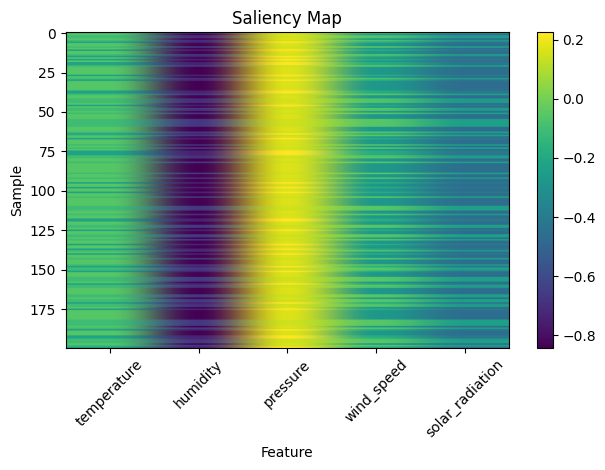

In [25]:
sal_vals = compute_saliency_map_keras(model, X_test)
plt.imshow(sal_vals, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Saliency Map")
plt.xlabel("Feature")
plt.ylabel("Sample")
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=45)
plt.tight_layout()
plt.show()

In [26]:
def simple_lrp_keras(model, X):
  """This function implements a simplified version of Layer-wise Relevance Propagation (LRP) for a Keras model.
  LRP is a technique used in explainable AI to understand the contribution of each input feature to the prediction of a neural network.
  In simpler terms, it helps us see which features were most important in the model's decision-making process."""

  # get weights and model biases
  weights1, biases1 = model.layers[0].get_weights()
  weights2, biases2 = model.layers[1].get_weights()

  # do a forward pass to calculate activations
  X_input = X.values
  # weighted sum of inputs plus bias for the first layer
  # dot product between two vectors can be interpreted as a weighted sum where the elements of
  # one vector are the weights, and the elements of the other vector are the values being weighted
  z1 = np.dot(X_input, weights1) + biases1
  # activation of the first layer (using ReLU - Rectified Linear Unit - which sets negative values to 0)
  a1 = np.maximum(z1, 0)
  # weighted sum of the first layer's activations plus bias for the second layer
  z2 = np.dot(a1, weights2) + biases2
  relevance_output = z2

  # backward pass
  # propagates the relevance backward from the output layer to the input layer
  # relevance at second layer
  R2 = relevance_output * weights2.T
  # relevance at first layer
  R1 = a1 * R2
  # relevance at input layer
  R0 = X_input * np.dot(R1, weights1.T)
  return R0

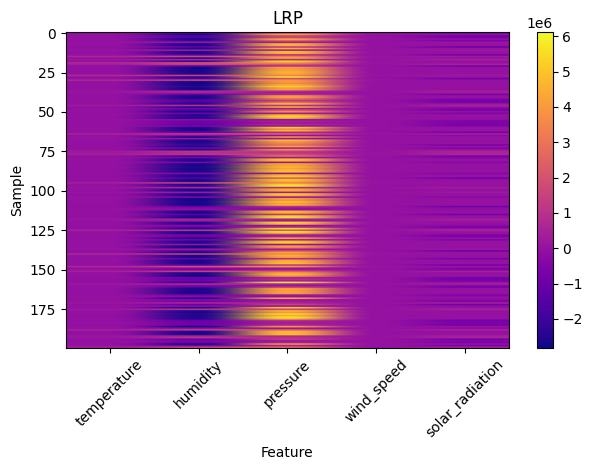

In [27]:
lrp_vals = simple_lrp_keras(model, X_test)
plt.imshow(lrp_vals, aspect='auto', cmap='plasma')
plt.colorbar()
plt.title("LRP")
plt.xlabel("Feature")
plt.ylabel("Sample")
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=45)
plt.tight_layout()
plt.show()

### Getting started on a 2D CNN

Note that these are quickly coded up and very new examples -- please check and verify software as you use it!

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [29]:
np.random.seed(0)
tf.random.set_seed(0)

# 1. Fake 2D Weather Data (e.g. 5x5 grid with 3 channels)
def generate_fake_2d_weather_data(n=1000, grid_size=5, channels=3):
    X = np.random.rand(n, grid_size, grid_size, channels).astype(np.float32)
    weights = np.random.randn(grid_size, grid_size, channels)
    y = np.sum(X * weights, axis=(1, 2, 3)) + np.random.normal(0, 0.1, n)
    return X, y

In [30]:
X, y = generate_fake_2d_weather_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
model = keras.Sequential([
    layers.Input(shape=(X.shape[1:])),
    layers.Conv2D(8, kernel_size=3, activation='relu'),
    layers.Flatten(),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, verbose=0)

In [32]:
preds = model.predict(X_test)
score = r2_score(y_test, preds)
print(f"R2 Score: {score:.3f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
R2 Score: 0.191


In [33]:
_ = model(X_train[:1])

In [34]:
explainer = shap.GradientExplainer(model, X_train[:200])
shap_vals = explainer.shap_values(X_test[:])

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_3
Received: inputs=['Tensor(shape=(200, 5, 5, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_3
Received: inputs=['Tensor(shape=(50, 5, 5, 3))']
  warnings.warn(msg)


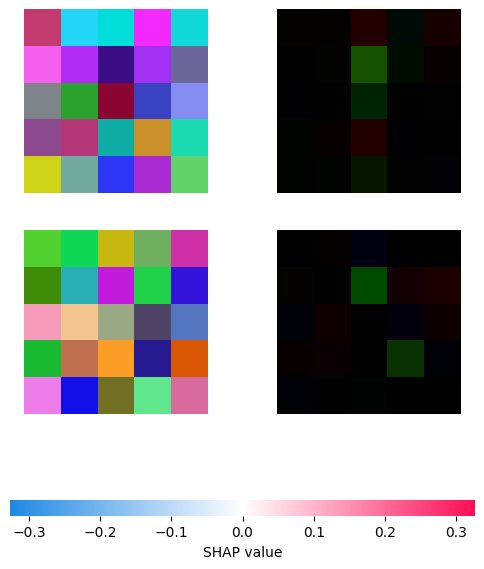

In [35]:
shap.image_plot(shap_vals, X_test[:2])

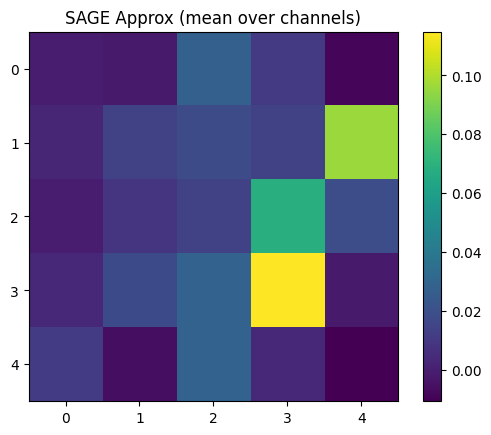

In [36]:
def sage_approx_cnn(model, X, y):
    base_loss = model.evaluate(X, y, verbose=0)
    importances = np.zeros(X.shape[1:])
    for i in range(X.shape[1]):
        for j in range(X.shape[2]):
            for k in range(X.shape[3]):
                X_permuted = np.copy(X)
                np.random.shuffle(X_permuted[:, i, j, k])
                permuted_loss = model.evaluate(X_permuted, y, verbose=0)
                importances[i, j, k] = permuted_loss - base_loss
    return importances

sage_vals = sage_approx_cnn(model, X_test, y_test)
plt.imshow(np.mean(sage_vals, axis=-1), cmap='viridis')
plt.colorbar()
plt.title("SAGE Approx (mean over channels)")
plt.show()

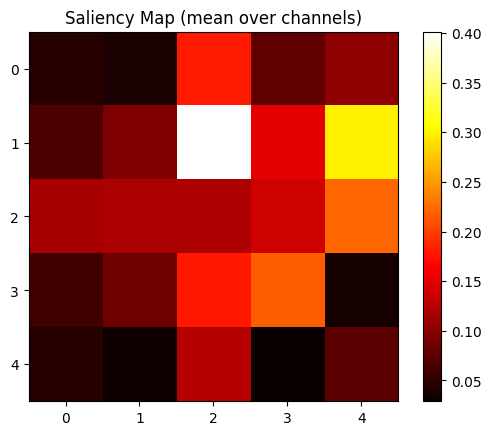

In [37]:
@tf.function
def compute_saliency_map(model, inputs):
    inputs = tf.convert_to_tensor(inputs)
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs)
    grads = tape.gradient(preds, inputs)
    return grads

saliency = compute_saliency_map(model, X_test[:10])
saliency_np = np.abs(saliency.numpy())
plt.imshow(np.mean(saliency_np[0], axis=-1), cmap='hot')
plt.colorbar()
plt.title("Saliency Map (mean over channels)")
plt.show()

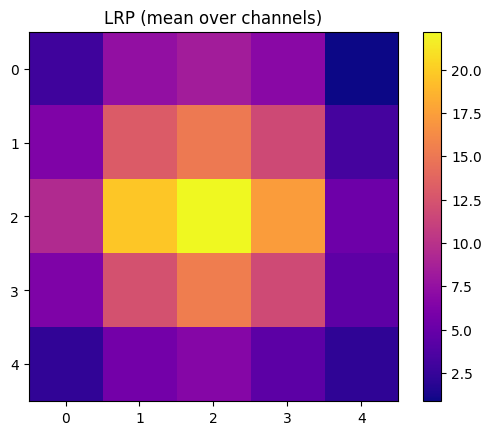

In [38]:
# Note: Naive and illustrative for small CNNs
def simple_lrp_cnn(model, X):
    conv_weights, conv_biases = model.layers[0].get_weights()
    dense_weights, dense_biases = model.layers[2].get_weights()

    conv_output = model.layers[0](X).numpy()
    flat_output = conv_output.reshape(X.shape[0], -1)
    z = np.dot(flat_output, dense_weights) + dense_biases
    relevance_output = z

    R_dense = relevance_output[:, None] * dense_weights.T
    R_conv = R_dense.reshape(conv_output.shape)
    R_input = np.zeros_like(X)

    for i in range(X.shape[0]):
        X_tensor = tf.convert_to_tensor(X[i:i+1], dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(X_tensor)  # Watch the TensorFlow tensor
            conv_output = model.layers[0](X_tensor)
        # Get gradients of conv_output w.r.t. input
        grads = tape.gradient(conv_output, X_tensor)

        for f in range(conv_weights.shape[3]):  # Use conv_weights here
            for c in range(conv_weights.shape[2]):  # Use conv_weights here
                # Use gradients instead of conv2d_transpose
                R_input[i, :, :, c] += grads[:, :, :, c][0]
    return R_input

lrp_vals = simple_lrp_cnn(model, X_test[:5])
plt.imshow(np.mean(lrp_vals[0], axis=-1), cmap='plasma')
plt.colorbar()
plt.title("LRP (mean over channels)")
plt.show()